In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import prepare_dataframes

In [2]:
movies, directors, awards = prepare_dataframes()

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


# Get more insights on what we have

In [3]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28478 entries, nm0000005 to nm9973247
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   primaryName        28478 non-null  string
 1   birthYear          15419 non-null  Int16 
 2   deathYear          7214 non-null   Int16 
 3   primaryProfession  28477 non-null  string
 4   knownForTitles     28464 non-null  string
 5   awardsNominated    28478 non-null  int64 
 6   awardsWon          28478 non-null  int64 
dtypes: Int16(2), int64(2), string(3)
memory usage: 1.5 MB


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73738 entries, tt0228333 to tt0354216
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   wikipediaID      73738 non-null  int32  
 1   freebaseID       73738 non-null  string 
 2   title            73738 non-null  string 
 3   revenue          8327 non-null   float64
 4   runtime          56843 non-null  float32
 5   release          68742 non-null  Int16  
 6   languages        73738 non-null  string 
 7   countries        73738 non-null  string 
 8   genres           73738 non-null  string 
 9   isAdult          73725 non-null  Int16  
 10  runtime_imdb     68154 non-null  Int32  
 11  genres_imdb      71954 non-null  string 
 12  rating           67838 non-null  float32
 13  votes            67838 non-null  float64
 14  directors        73178 non-null  string 
 15  awardsNominated  73738 non-null  int64  
 16  awardsWon        73738 non-null  int64  
dtypes: In

Usable information to popularity and success are: `revenue`, `rating`, and `votes`.

> Awards and nominations can be extracted by scraping IMDb. [Example](https://www.imdb.com/title/tt1302006/awards/) for awards of The Irishman. 

> The same thing can be done for directors but we would need to also generate mappings of FreebaseID to IMDb IDs of the directors.

> There is also a scraped dataset for The Oscar awards and nominations since 1927 on [Kaggle](https://www.kaggle.com/datasets/unanimad/the-oscar-award).

We have to rely on the ratings and votes, so let's dive into it and get some info.
However, it might be unfair to treat movies from all countries the same. Hollywood and Bollywood movies have usually a larger audience, for insntance.


In [5]:
countries = []
for item in movies.countries.str.split(','):
    countries.extend(item)
countries = set(countries)

print(f'We have movies from {len(countries)} countries in the world.')

We have movies from 144 countries in the world.


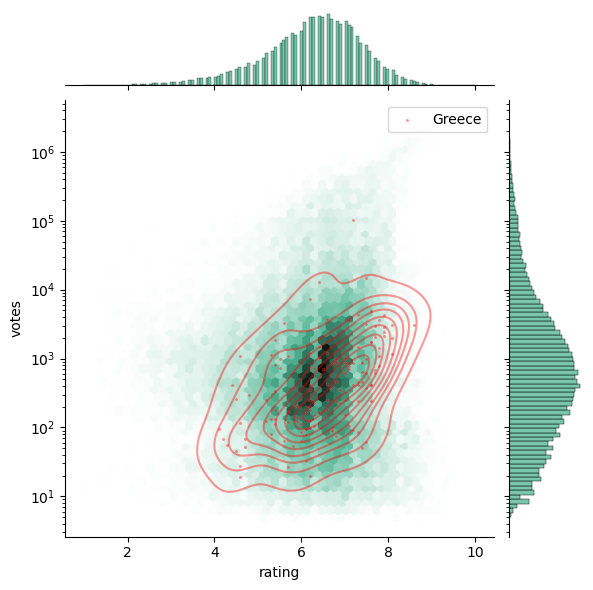

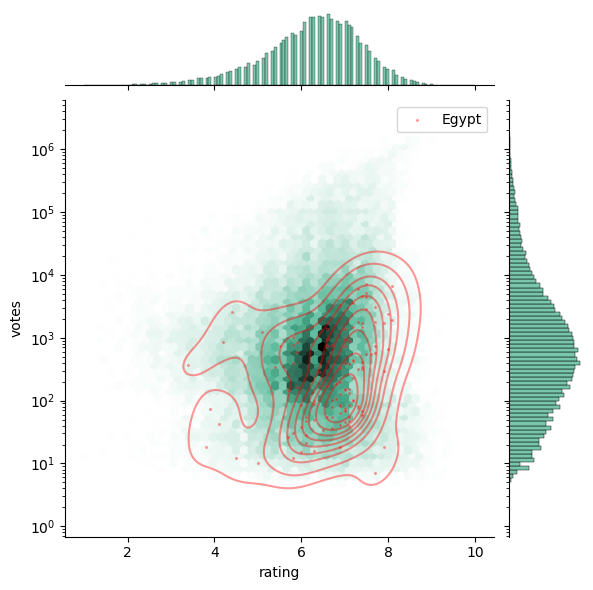

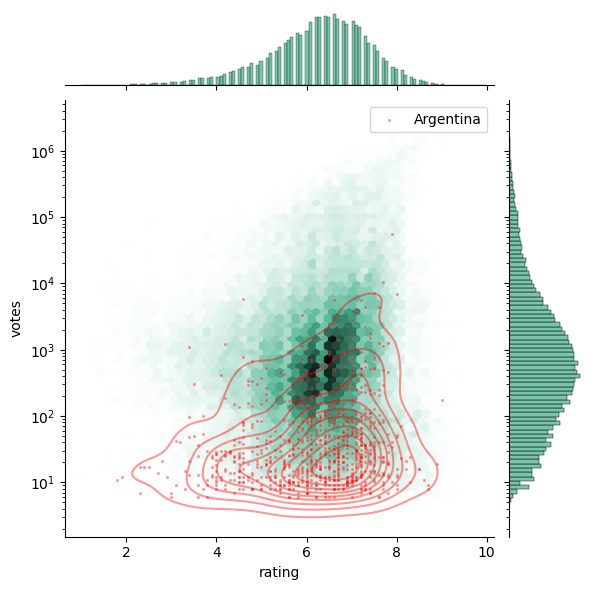

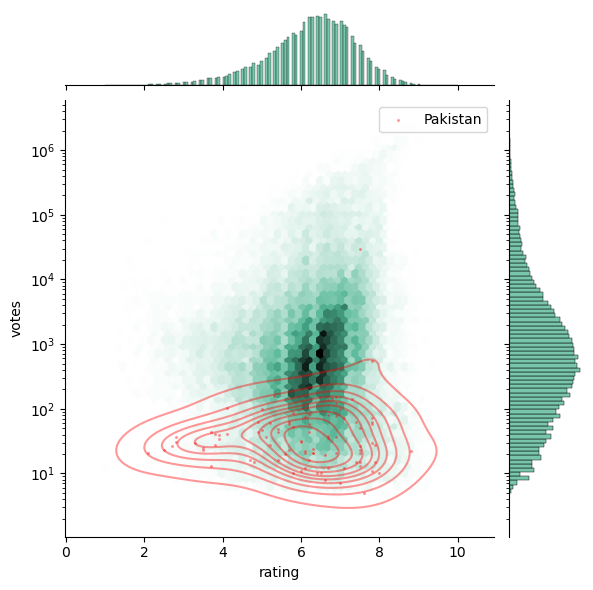

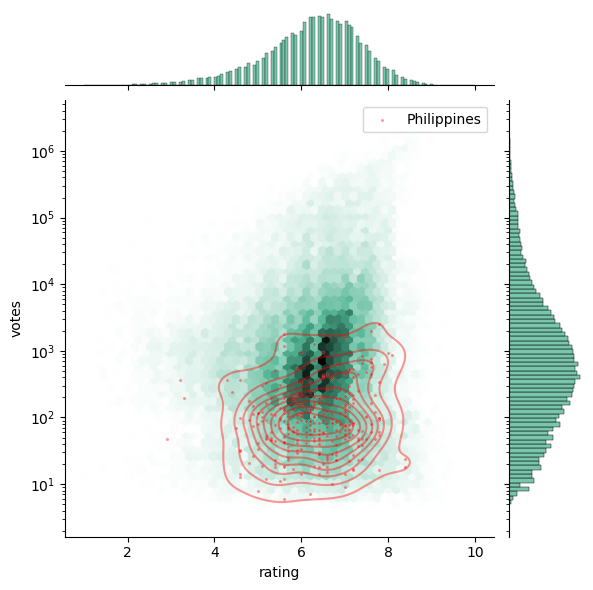

In [6]:
# NOTE: This can be an interactive plot in the final data story

for country in ['Greece', 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

# Define and assess a metric for movie success

Intuitively, number of votes shows the popularity of the movie, and the average rating shows a mix of its quality and its popularity.

Since we have only partial info about the revenue and awards, we can use them for assessing our metrics.

In [7]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

## Check top movies per country

In [8]:
def list_top_movies(country: str, top=10):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])

In [9]:
list_top_movies('Iran', top=10)

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt1832382,A Separation,44.848721,8.3,253198.0,NaN,2011,Drama
tt0118849,Children of Heaven,40.132846,8.2,78388.0,1628579.0,1997,"Family Film,Drama,Adventure,World cinema,Comedy"
tt1360860,About Elly,37.510196,7.9,55992.0,1350000.0,2009,"Mystery,Drama,World cinema"
tt0416960,Marmoulak,36.448384,8.4,21832.0,NaN,2004,Comedy
tt0100234,Close-up,35.589689,8.2,21888.0,NaN,1990,"Crime Fiction,Drama,World cinema,Documentary"
tt0120265,Taste of Cherry,34.945468,7.7,34544.0,NaN,1997,"Drama,World cinema"
tt0424227,Turtles Can Fly,34.475849,8.0,20393.0,NaN,2004,"Drama,Childhood Drama,World cinema,War film"
tt0191043,The Color of Paradise,34.452236,8.1,17921.0,NaN,2000,"Family Drama,Drama,Childhood Drama,World cinema"
tt0093342,Where Is the Friend's Home?,34.331630,8.1,17317.0,NaN,1987,"Drama,Childhood Drama"


> Almost all of them are great movies. Having the ones with rates `7.7` and `7.9` at top is a good sign because they are kinda underrated imo.

In [10]:
list_top_movies('United States', top=20)

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt0111161,The Shawshank Redemption,59.965840,9.3,2805044.0,2.834147e+07,1994,"Crime Fiction,Buddy film,Prison film,Drama,Esc..."
tt0468569,The Dark Knight,58.005896,9.0,2786760.0,1.004558e+09,2008,"Crime Fiction,Thriller,Superhero movie,Crime D..."
tt0068646,The Godfather,57.877736,9.2,1954602.0,2.685000e+08,1972,"Crime Fiction,Gangster Film,Crime Drama,Family..."
tt0167260,The Lord of the Rings: The Return of the King,56.550332,9.0,1920305.0,1.119930e+09,2003,"Fantasy Adventure,Adventure,Epic,Action/Advent..."
tt0110912,Pulp Fiction,56.361239,8.9,2151413.0,2.139288e+08,1994,"Crime Fiction,Thriller,Crime Comedy,Indie,Gang..."
tt1375666,Inception,56.261196,8.8,2473532.0,8.255328e+08,2010,"Thriller,Science Fiction,Adventure,Psychologic..."
tt0137523,Fight Club,55.880984,8.8,2239297.0,1.009000e+08,1999,"Thriller,Action/Adventure,Existentialism,Psych..."
tt0109830,Forrest Gump,55.784213,8.8,2183308.0,6.773877e+08,1994,"Coming of age,Comedy film,Drama,War film,Roman..."
tt0120737,The Lord of the Rings: The Fellowship of the Ring,55.349406,8.8,1948521.0,8.715303e+08,2001,"Fantasy Adventure,Adventure,Epic,Fantasy,Film ..."


> Not bad.

In [11]:
list_top_movies('France', top=20)

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt0103064,Terminator 2: Judgment Day,52.101748,8.6,1143780.0,519843345.0,1991,"Thriller,Science Fiction,Doomsday film,Action/..."
tt0361748,Inglourious Basterds,51.948135,8.4,1528629.0,320389438.0,2009,"Thriller,Black comedy,Action/Adventure,Drama,W..."
tt0110413,Léon: The Professional,51.707975,8.5,1211410.0,45284974.0,1994,"Thriller,Crime Fiction,Buddy film,Indie,World ..."
tt0317248,City of God,50.685414,8.6,782803.0,30641770.0,2002,"Crime Fiction,Thriller,Gangster Film,World cin..."
tt1675434,Intouchables,50.611053,8.5,899998.0,NaN,2011,"Biographical film,Drama,Comedy film"
tt0253474,The Pianist,50.528476,8.5,880089.0,120072577.0,2002,"History,Biographical film,Drama,War film"
tt0211915,Amélie,48.900780,8.3,779220.0,173921954.0,2001,"Romantic comedy,World cinema,Fantasy,Comedy,Dr..."
tt0112641,Casino,47.047697,8.2,546417.0,116112375.0,1995,"Crime Fiction,Biography,Gangster Film,Period p..."
tt0095765,Nuovo Cinema Paradiso,46.226951,8.5,274451.0,11990401.0,1988,Drama


## Check correlation of the scores with other movie characteristics

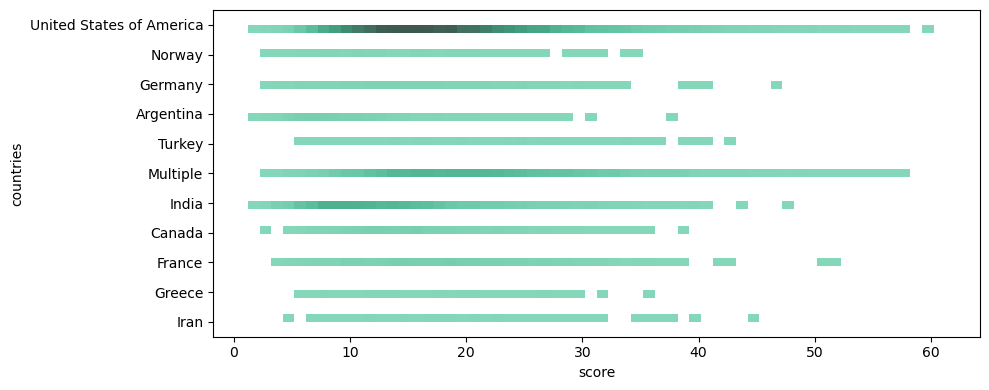

In [12]:
countries = ['United States of America', 'India', 'Turkey', 'France', 'Multiple', 'Germany', 'Norway', 'Greece', 'Canada', 'Argentina', 'Iran']
df = movies.copy()
df.loc[movies.countries.str.contains(','), 'countries'] = 'Multiple'
df = df[df.countries.isin(countries)]

fig, ax = plt.subplots(figsize=(10, 4))
g = sns.histplot(
    ax=ax,
    data=df,
    x='score',
    y='countries',
    discrete=(True, False),
    color='#4CB391'
)
plt.tight_layout()

/var/folders/rw/zplflm8s0mg64xxntr1x_bdr0000gn/T/ipykernel_90607/500197204.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  data=movies.dropna(subset='release').query('release > 1500'),


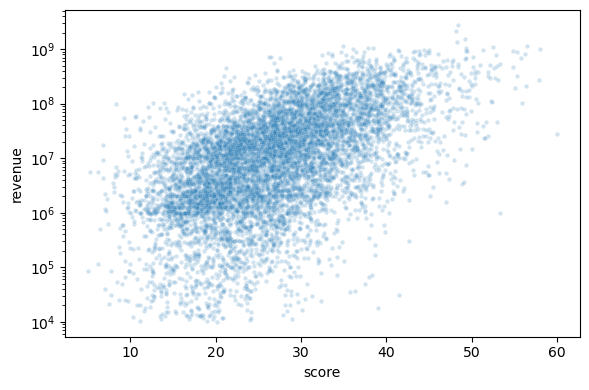

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
g = sns.scatterplot(
    ax=ax,
    data=movies.dropna(subset='release').query('release > 1500'),
    x='score',
    y='revenue',
    s=10,
    alpha=.2,
    # discrete=(False, True),
)
ax.set(yscale='log')
plt.tight_layout()

/var/folders/rw/zplflm8s0mg64xxntr1x_bdr0000gn/T/ipykernel_90607/2159670855.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  data=movies.dropna(subset='release').query('release > 1500'),


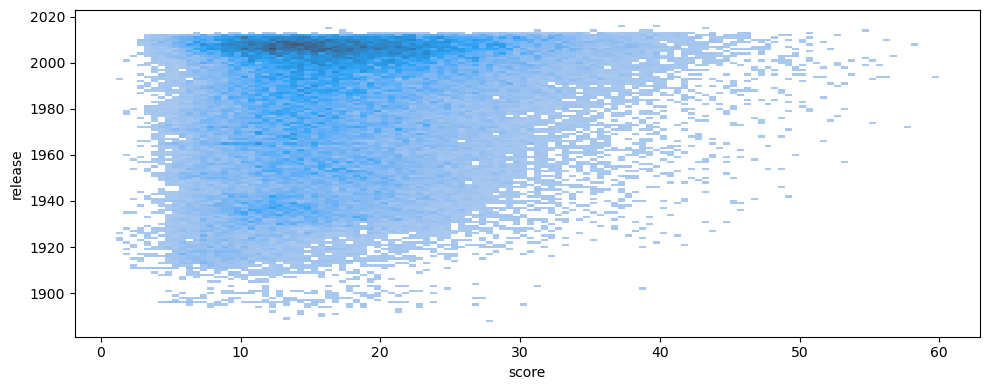

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.histplot(
    ax=ax,
    data=movies.dropna(subset='release').query('release > 1500'),
    x='score',
    y='release',
    discrete=(False, True),
)
plt.tight_layout()

# Define and assess a metric for director success

We can count the number of movies with scores higher than a threshold.

We can probably be more fair to directors from countries with smaller audiences by only considering the rating and apply a threshold on the number of votes.

We can also get the average score of the top movies of the directos.

In [15]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

Let's check some names:

In [16]:
directors.sort_values(by='avg-5', ascending=False)[:10].drop(['primaryProfession', 'knownForTitles'], axis=1)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0634240,Christopher Nolan,1970,<NA>,358,137,9,7,7,7,10,8,7,4,56.359359,54.76424,48.277678
nm0000233,Quentin Tarantino,1963,<NA>,421,161,11,8,7,4,10,9,7,2,53.710729,52.175466,47.488598
nm0000229,Steven Spielberg,1946,<NA>,382,189,25,13,7,3,21,15,7,2,52.930622,51.378904,48.343442
nm0000217,Martin Scorsese,1942,<NA>,429,161,25,10,7,4,33,22,12,3,51.938314,50.997257,47.283685
nm0000116,James Cameron,1954,<NA>,137,70,8,6,5,1,8,7,3,1,49.961564,49.2563,41.656368
nm0000040,Stanley Kubrick,1928,1999,99,43,11,9,5,1,11,11,7,0,49.593339,49.043534,45.40516
nm0000399,David Fincher,1962,<NA>,181,67,9,7,4,2,7,7,2,2,51.770668,49.031727,<NA>
nm0001392,Peter Jackson,1961,<NA>,270,137,9,4,3,3,8,4,3,3,55.600284,48.992753,40.917419
nm0000338,Francis Ford Coppola,1939,<NA>,96,49,10,4,3,2,10,6,4,3,54.015733,48.884288,42.252444


Let's check these metrics for award winning directors:

`avg-3` and `avg-5` seem to be more robust but there are too many missing values. We can go on but we will be left with 6k directors out of 28k.

There are 21970 missing scores (avg-3).


<Axes: xlabel='awardsWon', ylabel='avg-3'>

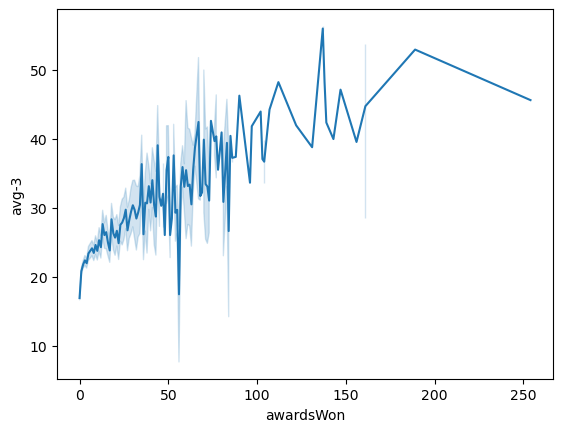

In [27]:
score = 'avg-3'

print(f'There are {directors[score].isna().sum()} missing scores ({score}).')

sns.lineplot(
    y=directors.dropna(subset=score)[score],
    x=(directors.awardsWon),
)

There are 21970 missing scores (avg-3).


<Axes: xlabel='awardsNominated', ylabel='avg-3'>

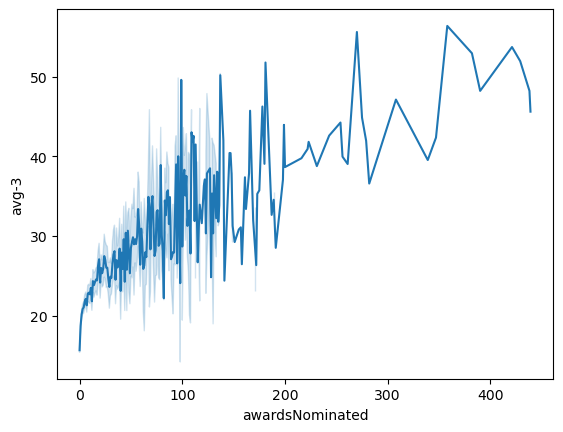

In [28]:
score = 'avg-3'

print(f'There are {directors[score].isna().sum()} missing scores ({score}).')

sns.lineplot(
    y=directors.dropna(subset=score)[score],
    x=(directors.awardsNominated),
)

`rate-7.0` and `rate-7.5` are also informative and there are no missing values but there seems to be no advantage of using these scores for determining successful directors because:

In [18]:
print(f'There are only {(directors["rate-7.0"] > 2).sum()} directors with at least three movie with rate > 7.0.')

print(f'{directors[directors["rate-7.0"] > 2]["avg-3"].isna().sum()} of these directors miss the avg-3 score.')

There are only 984 directors with at least three movie with rate > 7.0.
0 of these directors miss the avg-3 score.


`hits-40`, `hits-45` and `hits-50` can be used for detecting very few legendary directors.

<Axes: xlabel='hits-40', ylabel='avg-3'>

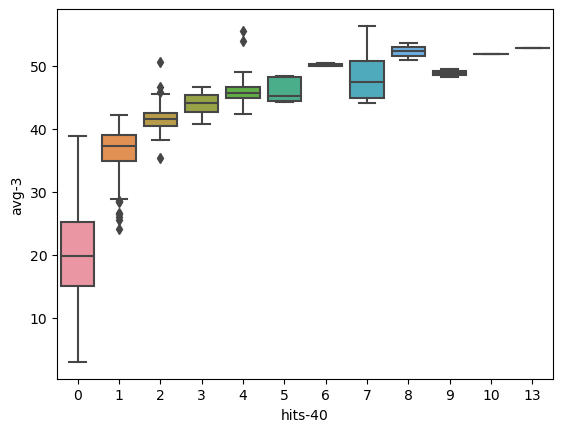

In [19]:
score = 'avg-3'
sns.boxplot(
    y=directors.dropna(subset=score)[score],
    x=(directors['hits-40']),
)

In [20]:
print(f'There are only {(directors["hits-40"] > 0).sum()} directors with at least one hit.')

There are only 420 directors with at least one hit.


# By-country director ranking

In [21]:
def get_directors_per_country(country: str):
    movies_country = movies[movies.countries.str.contains(country)]

    nmconsts = []
    for item in movies_country.dropna(subset='directors').directors.str.split(','):
        nmconsts.extend(item)
    nmconsts = set(nmconsts)

    return directors[directors.index.isin(nmconsts)]

def list_top_directors(country: str, top=15, score='avg-3'):
    dropcols = ['primaryProfession', 'knownForTitles']
    display(get_directors_per_country(country).sort_values(by=score, ascending=False)[:top].drop(dropcols, axis=1))

In [22]:
list_top_directors('Hong Kong', top=5)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0000217,Martin Scorsese,1942,<NA>,429,161,25,10,7,4,33,22,12,3,51.938314,50.997257,47.283685
nm0000631,Ridley Scott,1937,<NA>,137,44,16,6,3,2,12,6,3,2,50.39201,47.693042,43.326279
nm0000487,Ang Lee,1954,<NA>,199,102,9,3,1,0,9,7,0,0,43.949886,41.175461,36.716294
nm0000231,Oliver Stone,1946,<NA>,112,57,12,2,1,0,10,2,2,0,42.061817,40.121576,36.868459
nm0001752,Steven Soderbergh,1963,<NA>,113,30,15,2,0,0,9,2,0,0,41.488149,40.073533,37.704296


In [23]:
list_top_directors('Iran', top=5)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0327944,Alejandro G. Iñárritu,1963,<NA>,279,122,4,3,0,0,4,3,1,0,41.949604,37.726471,<NA>
nm0000080,Orson Welles,1915,1985,57,33,8,2,1,0,12,8,2,0,40.353561,37.559267,34.21558
nm1410815,Asghar Farhadi,1972,<NA>,165,86,3,1,0,0,4,4,1,0,37.88591,<NA>,<NA>
nm0000576,Sean Penn,1960,<NA>,175,73,2,1,1,0,1,1,1,0,35.739974,31.874882,<NA>
nm0006498,Majid Majidi,1959,<NA>,57,39,4,1,0,0,6,4,2,0,35.496518,32.781849,<NA>


In [24]:
list_top_directors('Russia', top=5)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0000041,Akira Kurosawa,1910,1998,94,67,17,5,1,0,27,17,12,1,44.257681,43.106949,40.457949
nm0001789,Andrei Tarkovsky,1932,1986,34,25,7,1,0,0,9,7,5,0,40.003469,38.867563,34.069939
nm0001120,Vittorio De Sica,1901,1974,43,28,4,1,0,0,14,6,3,0,37.082258,34.448853,31.224903
nm0758574,Walter Salles,1956,<NA>,91,58,3,0,0,0,6,3,1,0,36.871197,33.553927,28.844404
nm0301145,Leonid Gaidai,1923,1993,4,3,4,0,0,0,5,5,5,1,34.998947,33.743636,<NA>


In [25]:
list_top_directors('Poland', top=5)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0000591,Roman Polanski,1933,<NA>,178,90,16,3,2,1,14,5,3,1,46.250312,42.543666,38.569967
nm0000186,David Lynch,1946,<NA>,129,58,10,3,0,0,10,5,2,0,43.09809,41.687925,38.357482
nm0011470,Andrew Adamson,1966,<NA>,29,7,4,2,1,0,2,1,0,0,42.182388,37.497869,<NA>
nm0001425,Krzysztof Kieslowski,1941,1996,102,71,12,1,0,0,20,18,10,4,40.13863,38.774307,35.96134
nm0001885,Lars von Trier,1956,<NA>,216,104,9,1,0,0,9,5,2,0,39.762574,38.409429,35.009182


In [26]:
list_top_directors('Greece', top=5)

,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0001403,Neil Jordan,1950,<NA>,93,41,8,1,0,0,7,1,0,0,35.979749,34.306672,32.183104
nm0202088,Jules Dassin,1911,2008,16,7,4,0,0,0,6,5,1,0,33.865235,32.209488,28.484324
nm0677953,Donald Petrie,1954,<NA>,4,1,3,0,0,0,1,0,0,0,33.78716,31.184533,27.428438
nm0002020,Costa-Gavras,1933,<NA>,65,37,3,0,0,0,9,5,1,0,33.439561,31.594657,29.099886
nm0218547,Zeki Demirkubuz,1964,<NA>,60,41,2,0,0,0,4,3,1,0,32.113148,28.869617,<NA>
